In [1]:
from tars import Tars, markets, portfolios, traders, strategies
from tars.utils import data
import pandas as pd
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


# Backtester

## During strategy development

In [12]:
import pandas as pd
from tars.evaluators.trader_evaluator import TraderEvaluator
from tars.strategies.abstract_strategy import AbstractStrategy
from tars.markets.crypto_market import CryptoMarket


class PredictionStrategy(AbstractStrategy):
    """
    Prediction Strategy

    :param trader: Trader
        The Trader handling a portfolio
    :param pair: str
        The pair e.g. XETHZUSD to buy and hold
    :param volume: float
        The volume of the pair's quote buy
    :param validate: boolean
        Safety Boolean to make sure not to trade real money by default

    :ivar evaluator: AbstractEvaluator
        Evaluator allows for the evaluation of a strategy
    :ivar market: AbstractMarket
        Market object to get information from
    """

    def __init__(self, trader, pair, volume, data=None, validate=True):
        self.name = 'Prediction'
        self.trader = trader
        self.pair = pair
        self.volume = volume
        self.validate = validate
        self.evaluator = TraderEvaluator(self.trader)
        self.market = CryptoMarket()    

    def run(self):
        """ Run the strategy """
        # 1. Add a checkpoint to the evaluator
        balance = self.trader.portfolio.get_trade_balance().loc['eb'].ZUSD   
        self.evaluator.add_checkpoint(pd.Timestamp.utcnow(), balance)
        
        # 2. Process the data
        market = CryptoMarket()

        # get last frame
        df = market.get_ohlc_data(pair=self.pair, ascending=True, interval=15)[0]

        # preprocessing
        ts = TimeSeries.from_dataframe(df.reset_index(), 'dtime', 'close')

        # modeling
        model = ExponentialSmoothing()
        model.fit(ts)

        # 3. Get the relevant informations for trading decision
        prediction = round(model.predict(2).last_value(),2)
        current = df.iloc[-1]['close']

        # 4. Implement the trading logic
        if prediction < current:
            self.trader.add_order(pair=self.pair, type='sell',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)

        elif prediction >= current:
            self.trader.add_order(pair=self.pair, type='buy',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)
        else:
            pass
        
    def backtest(self):
        """ Backtest the strategy """

        # 1. Add a checkpoint to the evaluator
        balance = self.trader.portfolio.get_trade_balance().loc['eb'].ZUSD   
        self.evaluator.add_checkpoint(data.index[0], balance)
        
        # 2. Process the data
        market = CryptoMarket()

        # get last frame
        df = market.get_ohlc_data(pair=self.pair, ascending=True, interval=15)[0]

        # preprocessing
        ts = TimeSeries.from_dataframe(df.reset_index(), 'dtime', 'close')

        # modeling
        model = ExponentialSmoothing()
        model.fit(ts)

        # 3. Get the relevant informations for trading decision
        prediction = round(model.predict(2).last_value(),2)
        current = df.iloc[-1]['close']

        # 4. Implement the trading logic
        if prediction < current:
            self.trader.add_order(pair=self.pair, type='sell',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)

        elif prediction >= current:
            self.trader.add_order(pair=self.pair, type='buy',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)
        else:
            pass


## During usage

In [13]:
api_key = f'../kraken.key'

In [15]:
portfolio_1 = portfolios.VirtualPortfolio({'ZUSD': 1000})
trader_1 = traders.VirtualCryptoTrader(portfolio_1)
strategy_1 = strategies.BuyAndHold(trader_1, 'XETHZUSD', 0.2)

portfolio_2 = portfolios.VirtualPortfolio({'ZUSD': 1000})
trader_2 = traders.VirtualCryptoTrader(portfolio_2)
strategy_2 = PredictionStrategy(trader_2, 'XETHZUSD', 0.2)

In [16]:
# Create Tars and load strategies
tars = Tars()
tars.load(strategy_1)
tars.load(strategy_2)

 ü§ñ TARS : Welcome to Endurance! üë®‚ÄçüöÄ
 ü§ñ TARS : Loaded strategy ‚û°Ô∏è Buy and hold
 ü§ñ TARS : Loaded strategy ‚û°Ô∏è Prediction


### Run on a dataset to backtest

In [6]:
data = data.get_historical_ohlc_data(base='ETH', quote='USD', interval=1, data_folder='../../data/raw/')['2021':]

In [ ]:
tars.start(data)

### Run on real time

In [5]:
tars.start('00:00:10')

 ü§ñ TARS : Starting trading session üìà
 ‚è± Trading decision will be taken every : 00:00:10Ô∏è (hh:mm:ss)
 üí™Ô∏è Loading :   
   üßµ 'Thread-4' ‚û°Ô∏è 'Buy and hold'
   üßµ 'Thread-5' ‚û°Ô∏è 'Sequential Investment'


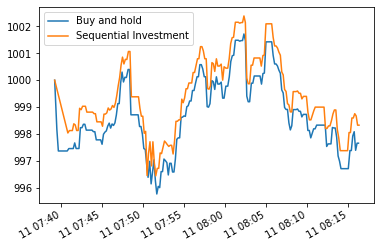

In [74]:
tars.plot()

In [16]:
tars.evaluate()

Buy and hold  Sequential Investment
2021-08-11 07:39:00+00:00       1000.00                1000.00
2021-08-11 07:40:00+00:00        997.37                 998.04
2021-08-11 07:41:00+00:00        997.46                 998.13

In [20]:
tars.stop()

---

In [ ]:
def backtest(data, frequency, duration=None) -> NoReturn:
        """
        Start a backtesting session
        :param data: DataFrame
            OHLCV Data in a Pandas DataFrame 
        :param frequency: str
            Frequency in the same form than a Pandas' Timedelta
        :param duration: str
            Frequency in the same form than a Pandas' Timedelta
        """
        if self.strategies:
            logging.info(f"{self._tars} : Starting backtesting session üìà")
            logging.info(f"‚è± Trading decision will be taken every : {frequency}Ô∏è (hh:mm:ss)")
            if duration is not None:
                logging.info(f"‚è≥ for a duration of : {duration} (hh:mm:ss)")
            logging.info(f"üí™Ô∏è Loading :   ")
            for i, s in enumerate(self.strategies):
                runner = BacktestRunner()
                self.runners.append(runner)
                thread = Thread(target=runner.start,
                                args=(data, s.run, frequency, duration))
                thread.start()
                logging.info(f"  üßµ '{thread.name}' ‚û°Ô∏è '{s.name}'")
            self.is_running = True
        else:
            raise Exception('There are no loaded strategies')

In [ ]:
import logging
from typing import Callable, NoReturn
from time import sleep

from pandas import Timestamp, Timedelta


class BacktestRunner:
    """
    A BacktestRunner represent an object able to execute a function through time on a given dataset.

    The function can be executed with a chosen frequency e.g. every 10 seconds
    and for a optional duration e.g. 2 hours.

    :ivar is_running : Boolean describing if the Runner is running or not.
    """
      
    def __init__(self):
        self.is_running = False

    def start(self, data: DataFrame, func: Callable, frequency: str, duration: str = None) \
            -> NoReturn:
        """ Start the Runner

        :param data: The data to use
        :param func: The function to be executed
        :param frequency: String representing a frequency in the same form than a Pandas' Timedelta (https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html)
        :param duration: String representing a frequency in the same form than a Pandas' Timedelta (https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html)
        """
        self.is_running = True
        
        # Initialize
        start_time = curr_year.index[0]
        end_time = curr_year.index[-1]
        current_time = start

        if duration is not None:
            duration_end_time = start + Timedelta(duration)
        
        while self.is_running or current_time <= end_time:
            if duration is not None:
                if current_time >= duration_end_time:
                    break
            func()
            current_time += Timedelta(frequency)

        logging.debug(f'Runner started with frequency of {frequency} and '
                      f'duration of {duration}')

    def stop(self) -> NoReturn:
        """ Stop the Runner """
        self.is_running = False
        logging.debug(f'Runner stopped')
